In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler



In [ ]:
df = pd.read_csv('data/Traffic.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [7]:
df.shape
#Get date range
print('Start date:', df['Date'].min())
print('End date:', df['Date'].max())


Start date: 1970-01-01 00:00:00.000000001
End date: 1970-01-01 00:00:00.000000031


In [243]:
import pandas as pd
import numpy as np

# Convert 'Time' to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.time

# Encode hours as sine and cosine
df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df.drop(columns=['Time', 'hour'], inplace=True)  # Drop original 'Time' column


In [244]:
df = pd.get_dummies(df, columns=['Day of the week'], drop_first=True)

In [245]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Traffic Situation'] = label_encoder.fit_transform(df['Traffic Situation'])
df = pd.get_dummies(df, columns=['Traffic Situation'], drop_first=True)



In [246]:
lags = 3  # Number of lag steps to include
for i in range(1, lags + 1):
    df[f'Total_lag_{i}'] = df['Total'].shift(i)

df.dropna(inplace=True)  # Drop rows with NaN values created by lagging



In [247]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total'] + \
                     [f'Total_lag_{i}' for i in range(1, lags + 1)] + \
                     ['hour_sin', 'hour_cos']
df[numerical_features] = scaler.fit_transform(df[numerical_features])




In [248]:
X = df.drop(columns=['Total']).values
y = df['Total'].values




In [249]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])  # Sequence of time_steps
        y_seq.append(y[i + time_steps])  # Target is the next step
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)



In [250]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)






In [251]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [272]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9141 - mae: 0.5748 - val_loss: 0.0930 - val_mae: 0.2397
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0577 - mae: 0.1964 - val_loss: 0.0658 - val_mae: 0.2011
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0399 - mae: 0.1592 - val_loss: 0.0612 - val_mae: 0.1876
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - mae: 0.1463 - val_loss: 0.0543 - val_mae: 0.1729
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - mae: 0.1386 - val_loss: 0.0397 - val_mae: 0.1526
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0281 - mae: 0.1361 - val_loss: 0.0431 - val_mae: 0.1526
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0247 - mae: 0.1240 - val_loss: 0.0371 - val_mae: 0.1436
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - mae: 0.1226 - val_loss: 0.0432 - val_mae: 0.1544
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.021

In [274]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")


Test Loss: 0.016004620119929314, Test MAE: 0.09976279735565186


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


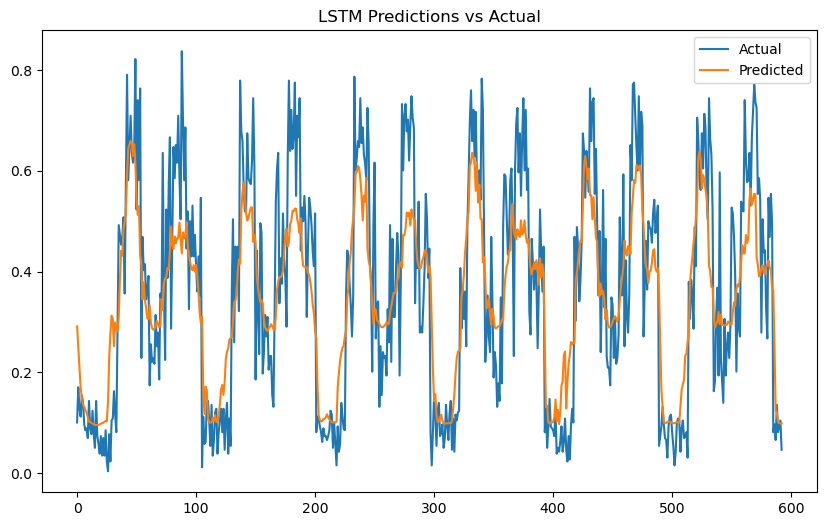

In [275]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()


In [280]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, LeakyReLU
from tensorflow.keras import layers

model2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LeakyReLU(alpha=0.1),  # Add Leaky ReLU after LSTM
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    LeakyReLU(alpha=0.1),
    LayerNormalization(),  # Normalize outputs of the LSTM layer
    Dropout(0.3),
    LSTM(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(1)  # Single output for regression
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
history2 = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0747 - mae: 0.2253 - val_loss: 0.0560 - val_mae: 0.1990
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0514 - mae: 0.1911 - val_loss: 0.0363 - val_mae: 0.1558
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0342 - mae: 0.1520 - val_loss: 0.0341 - val_mae: 0.1447
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0291 - mae: 0.1354 - val_loss: 0.0243 - val_mae: 0.1179
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0231 - mae: 0.1174 - val_loss: 0.0193 - val_mae: 0.1092
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0235 - mae: 0.1173 - val_loss: 0.0277 - val_mae: 0.1279
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0206 - mae: 0.1102 - val_loss: 0.0221 - val_mae: 0.1144
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0189 - mae: 0.1063 - val_loss: 0.0226 - val_mae: 0.1171
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


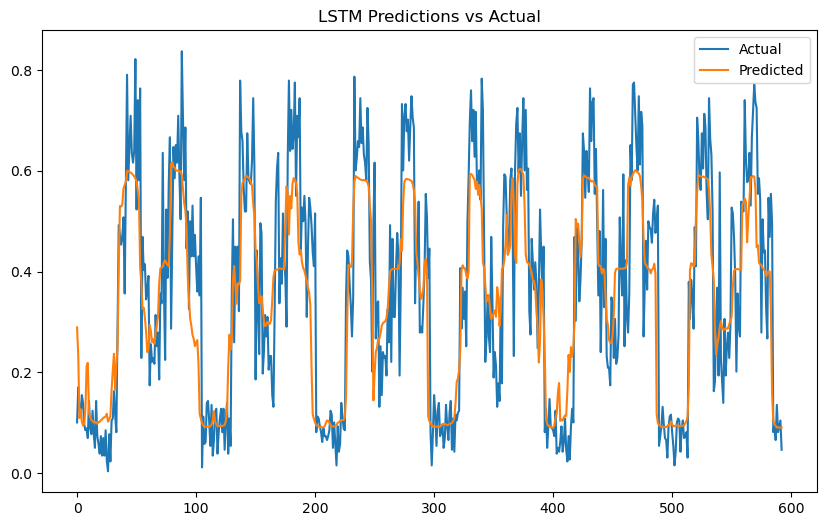

In [282]:
import matplotlib.pyplot as plt

y_pred = model2.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()

In [283]:
loss, mae = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Test Loss: 0.015001216903328896, Test MAE: 0.09264501929283142


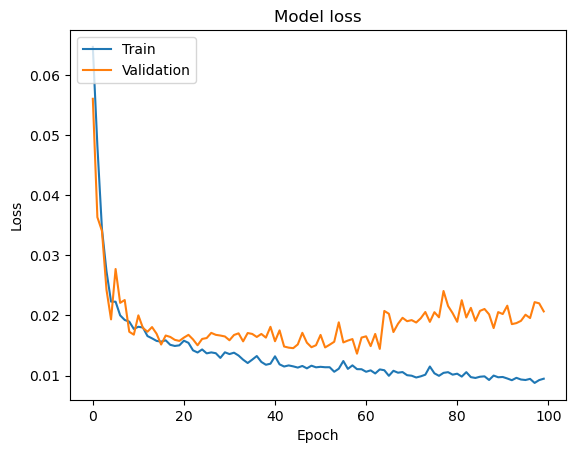

In [284]:
#graph of training
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#RN